## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'approx1e5-spaceNet-fourier-red' # Dataset Format: size-name-transform-channel

In [2]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
path_dict = dict(zip(['size', 'name', 'transform', 'channel'], DATA_NAME.split("-")))
CWD = os.path.join(ROOT_DIR, os.path.join("results", "case-studies", path_dict['name'], path_dict['transform'], path_dict['size'], path_dict['channel']))
assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "groupCDFs")).mkdir(exist_ok=True)

GROUP = 'layer' if path_dict['transform'] == 'wavelet' else ('band' if path_dict['transform'] == 'fourier' else 'error')
RERUN = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/fourier/approx1e5/red'

In [3]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [4]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{DATA_NAME}-size.pickle'))

if path_dict['transform'] == 'fourier':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif path_dict['transform'] == 'wavelet':
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = [os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)]
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[1:]:
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::1000] for g in GROUPS} # For quick testing purposes
group_total_samples

{2: 47614,
 3: 54416,
 4: 61218,
 5: 102030,
 6: 156446,
 7: 197258,
 8: 326496,
 9: 421724,
 10: 639388,
 11: 904666,
 12: 1312786,
 13: 1904560,
 14: 2727602,
 15: 3958764,
 16: 5720482,
 17: 8298440,
 18: 11957916,
 19: 17270278,
 20: 25140192,
 21: 36322680,
 22: 52586262,
 23: 65734528,
 24: 32003410}

/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:582: RuntimeWarning: invalid value encountered in scalar divide
  var_prior = scale * scipy.special.gamma(beta + 1/r)/scipy.special.gamma(beta)
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamm

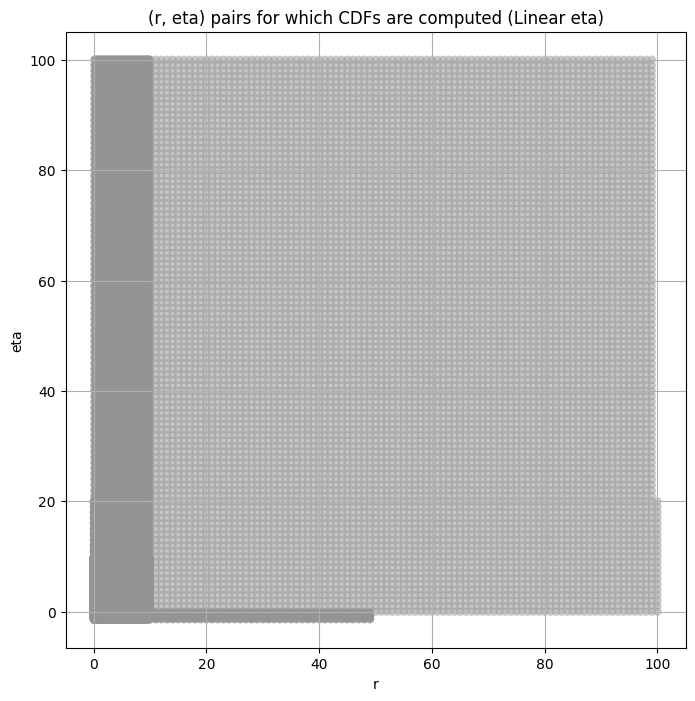

(r,eta),cdf     r  eta  \
0  ((0.02, -1.4), <scipy.interpolate._fitpack2.In...  0.02 -1.4   
1  ((0.02, -1.3), <scipy.interpolate._fitpack2.In...  0.02 -1.3   
2  ((0.02, -1.2), <scipy.interpolate._fitpack2.In...  0.02 -1.2   
3  ((0.02, -1.1), <scipy.interpolate._fitpack2.In...  0.02 -1.1   
4  ((0.02, -1.0), <scipy.interpolate._fitpack2.In...  0.02 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  9.618487e+69   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.821735e+74   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.455488e+78   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.406735e+81   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  5.331443e+83   

       kurtosis  
0  1.391529e+25  
1  8.172634e+21  
2  4.131785e+19  
3  6.947275e+17  
4  2.562075e+16

In [5]:
#warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
coarse_cdf_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 0) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 0) == all_cdfs_df['eta'])]
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [6]:
n_bootstrap = int(1e5)
bootstrap_size = int(1e4)
ci = 0.99

In [7]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists():
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


100%|██████████| 100000/100000 [01:13<00:00, 1353.10it/s]


Band 5


100%|██████████| 100000/100000 [01:11<00:00, 1393.21it/s]


Band 8


100%|██████████| 100000/100000 [08:14<00:00, 202.22it/s] 


Band 11


100%|██████████| 100000/100000 [07:17<00:00, 228.80it/s]


Band 14


100%|██████████| 100000/100000 [00:44<00:00, 2262.51it/s]


Band 17


100%|██████████| 100000/100000 [00:43<00:00, 2303.43it/s]


Band 20


100%|██████████| 100000/100000 [00:43<00:00, 2289.61it/s]


Band 23


100%|██████████| 100000/100000 [00:43<00:00, 2307.66it/s]


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  
band                              
2        8.210644        47614.0  
5       14.530108       102030.0  
8       28.603450       326496.0  
11      17.436117       904666.0  
14      27.891136      2727602.0  
17     200.073470      8298440.0  
20    1304.633700     25140192.0  
23     247.719700     65734528.0

## Initial Grid Search and Hypothesis Test Plots

####
Band  2


100%|██████████| 55966/55966 [01:30<00:00, 619.04it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 47614, Without approximation : 47614.0


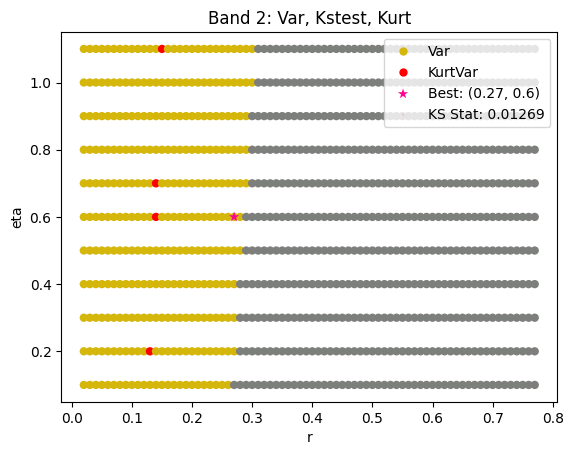

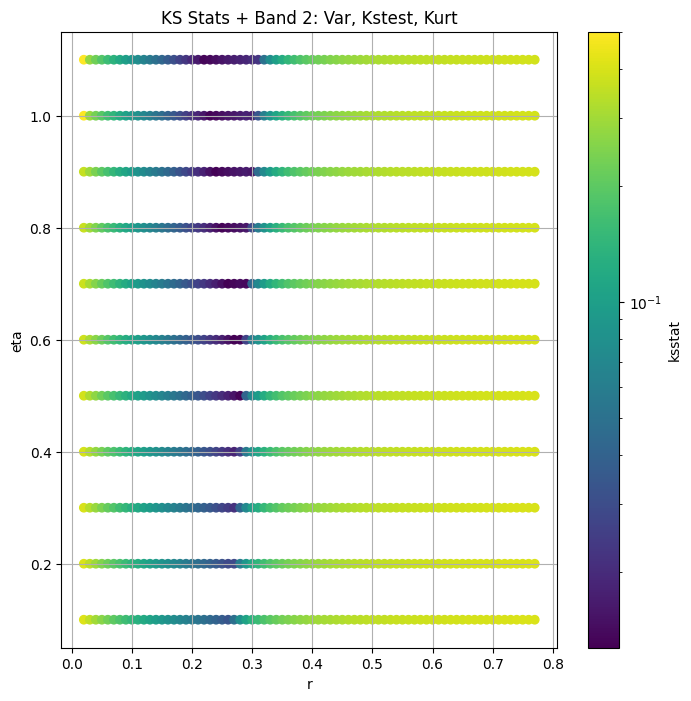

####
Band  5


100%|██████████| 55966/55966 [03:02<00:00, 306.17it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 102030.0


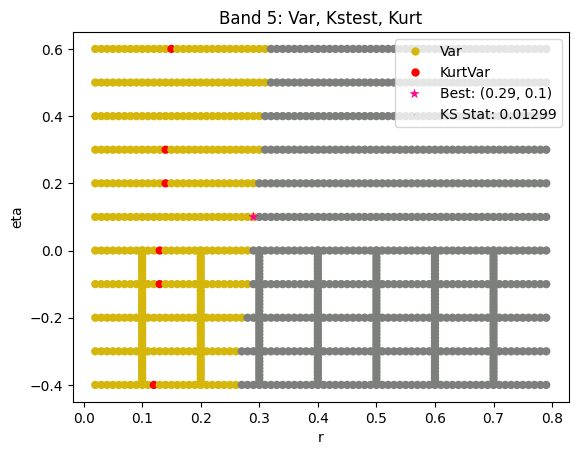

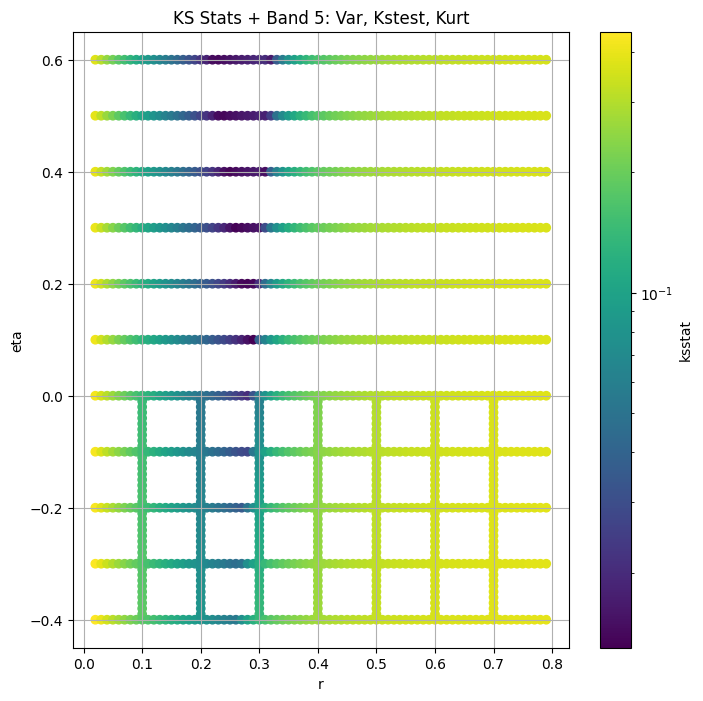

####
Band  8


100%|██████████| 55966/55966 [03:02<00:00, 306.98it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 326496.0


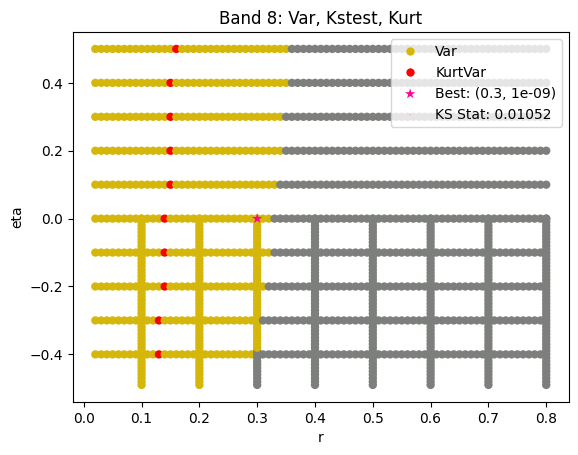

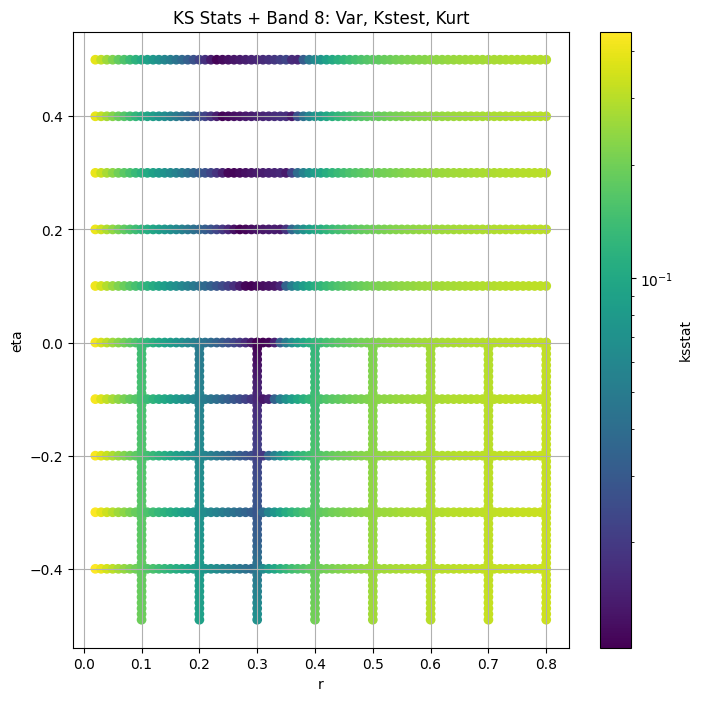

####
Band  11


100%|██████████| 55966/55966 [02:59<00:00, 311.22it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 904666.0


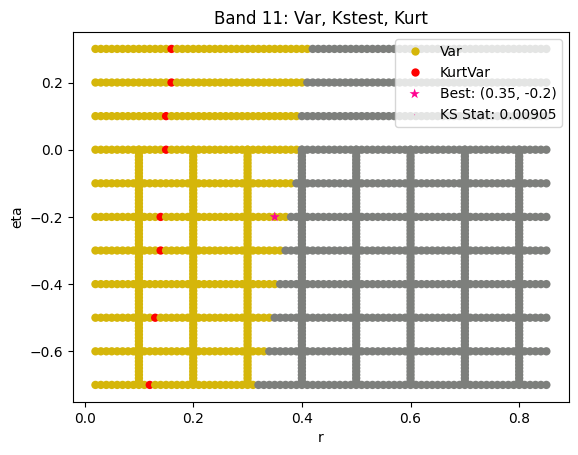

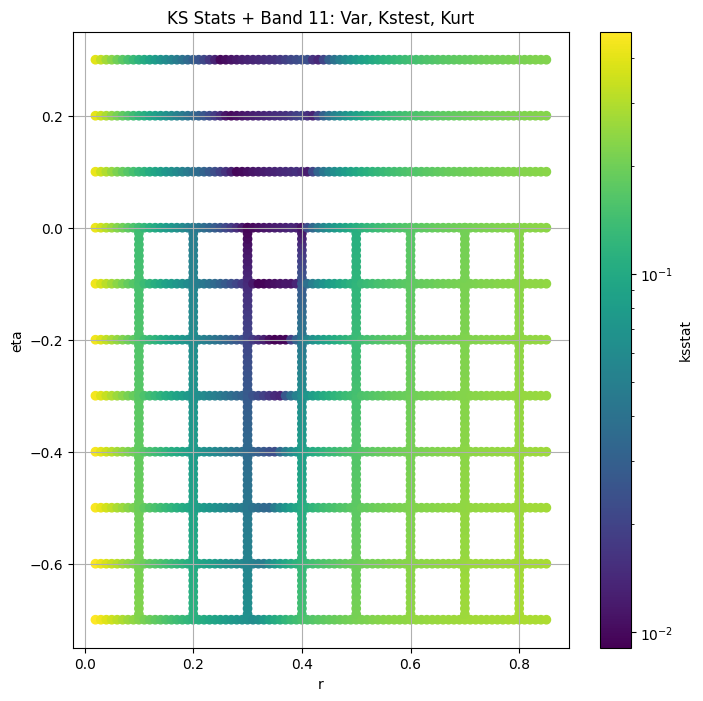

####
Band  14


100%|██████████| 55966/55966 [02:59<00:00, 312.39it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 2727602.0


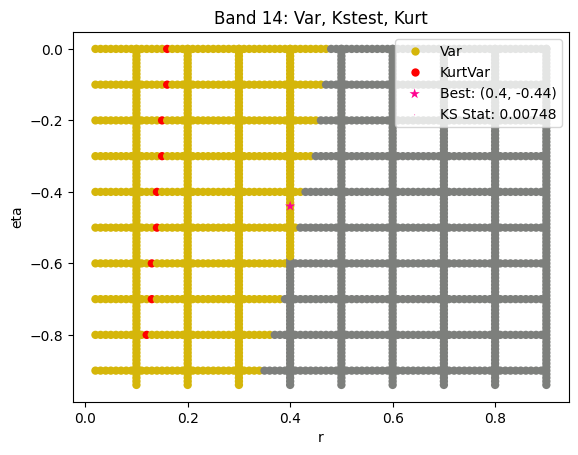

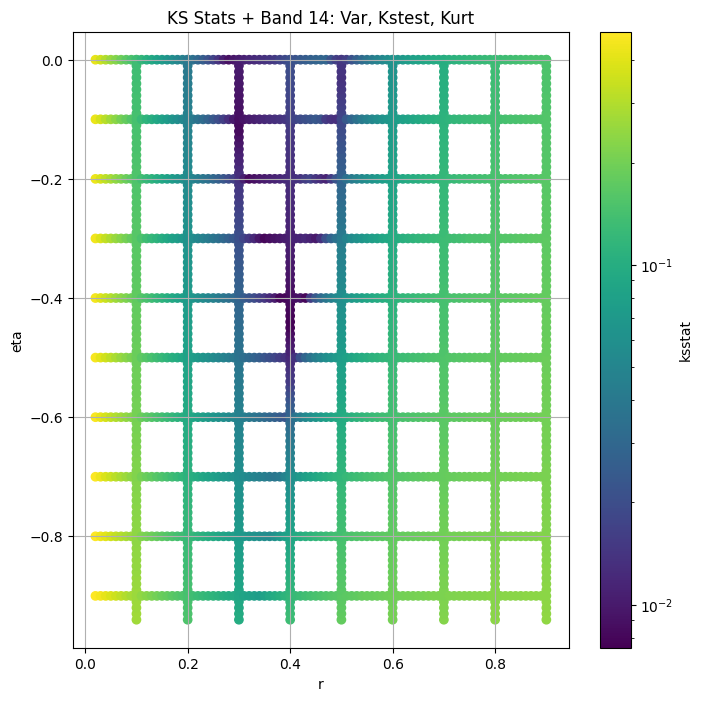

####
Band  17


100%|██████████| 55966/55966 [02:59<00:00, 312.01it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 8298440.0


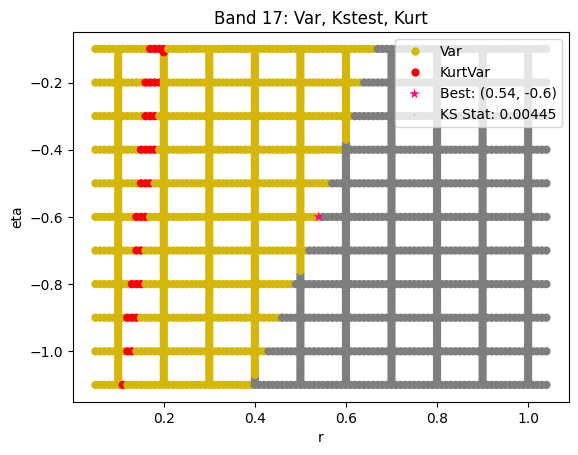

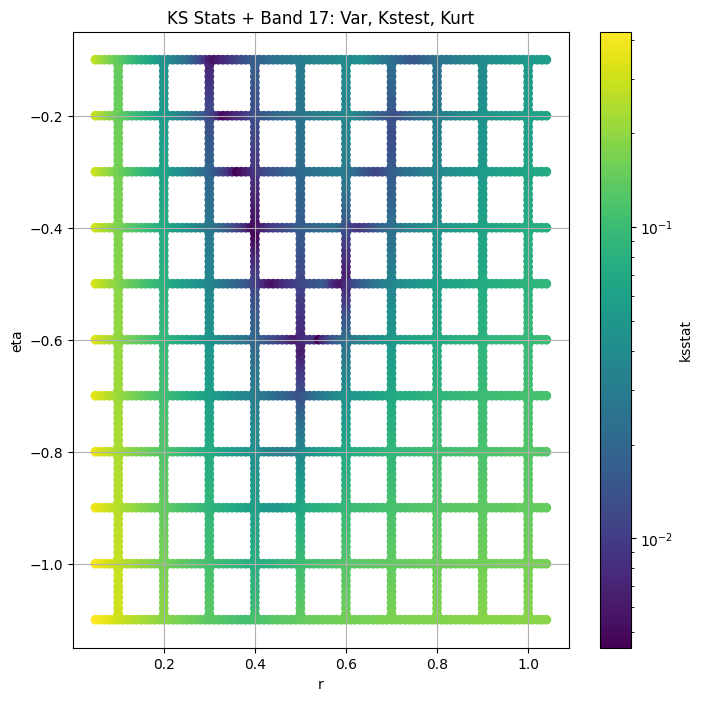

####
Band  20


100%|██████████| 55966/55966 [02:59<00:00, 311.20it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 25140192.0


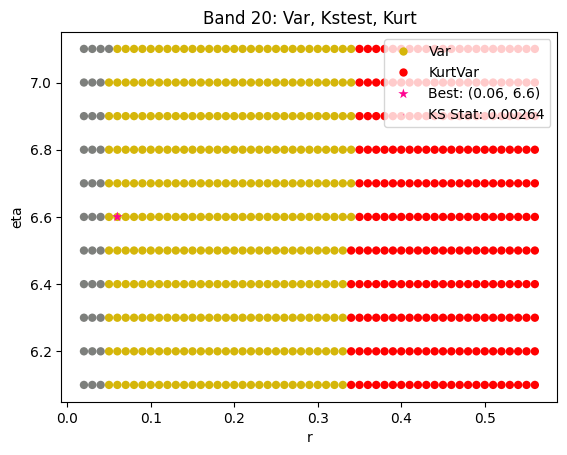

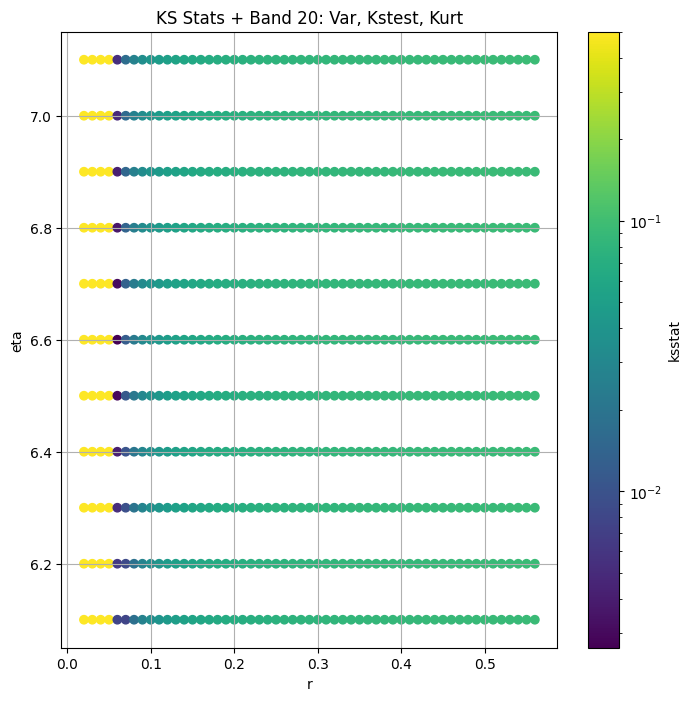

####
Band  23


100%|██████████| 55966/55966 [03:02<00:00, 307.38it/s]


Finding Minimum after computing 55966 CDFs
Number of samples: 100000, Without approximation : 65734528.0


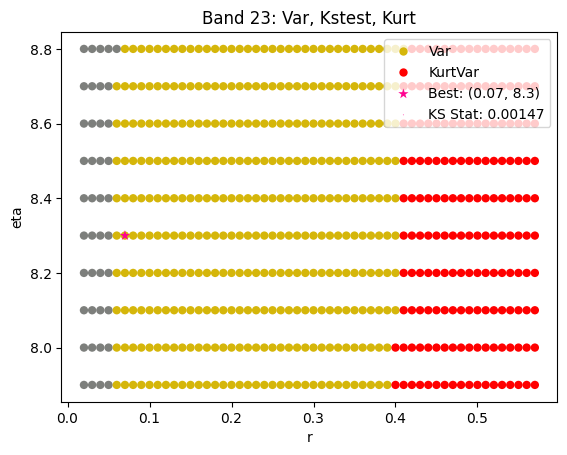

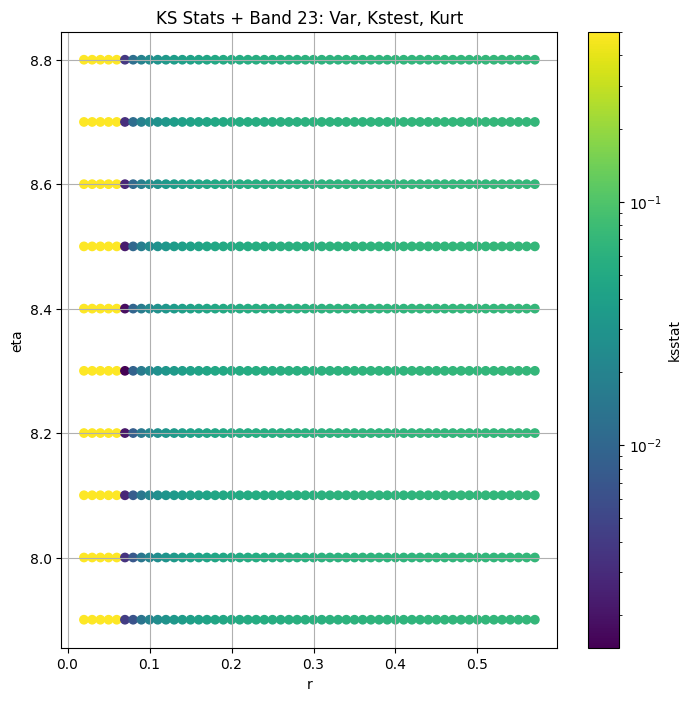

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  initial_r   initial_eta  initial_scale  \
band                                                                       
2        8.210644        47614.0       0.27  6.000000e-01   5.356433e+04   
5       14.530108       102030.0       0.29  1.000000e-01   1.000000e+05   
8       28.603450       326496.0       0.30  1.000000e-09   4.876507e+04   
11      17.436117       904666.0       0.35 -2.000000e-01   6.909635e+04   
14      27.891136      2727602.0       0.40 -4.400000e-01   8.172318e+04   
17     200.073470      8298440.0       0.54 -6.000000e-01   1.000000e+05   
20    1304.633700     25140192.0       0.06  6.600000e+00   8.466925e-32   
23     247.719700     65734528.0       0.07  8.300000e+00   1.826442e-27   

      kstest_stat_initial  kstest_stat_cutoff_0.05  
band                                                
2                0.012691                 0.006220  
5                0.012990                 0.004250  
8                0.010517                 0.002376  
11               0.009053                 0.001428  
14               0.007477                 0.000822  
17               0.004447                 0.000471  
20               0.002639                 0.000271  
23               0.001467                 0.000168

In [8]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    group_cdf_df_dict = dict()
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS):
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        group_cdf_df = all_cdfs_df.copy()
        
        group_cdf_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / group_cdf_df['variance'], 0, 1e5)
        ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdf_df['scale'])
        initial_scale = group_cdf_df.loc[(group_cdf_df["r"] ==  initial_param[0]) & (group_cdf_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
        master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
        master_df.loc[group, 'initial_scale'] = initial_scale
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        master_df.loc[group, 'kstest_stat_initial'] = min_stat
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        group_cdf_df['variance'] = group_cdf_df['variance'] * group_cdf_df['scale']
        group_cdf_df['kurtosis'] = group_cdf_df['kurtosis'] * group_cdf_df['scale']

        group_cdf_df = add_tests_to_df(cdfs_df = group_cdf_df, group = group, var_kurt_df = master_df, ksstats = ksstats)
        group_cdf_df_dict[group] = group_cdf_df
        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdf_df_dict[group], cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])}", 
                            target_var = None,
                            best_param = initial_param,
                            best_ksstat=min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdf_df_dict[group], var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdf_df_dict[group], kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_combo.csv"))

master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
master_df

### Search over $\eta=0$

In [9]:
master_df_eta0_path = Path(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

if RERUN or not master_df_eta0_path.exists():
    best_params_eta0 = []
    for i, group in enumerate(GROUPS):
        if master_df.loc[group, 'initial_eta'] != 0:
            sample = group_data_map[group]
            group_cdf = all_cdfs_df[all_cdfs_df['eta'] == 0]
            cdfs_dict = {i[0]:i[1] for i in group_cdf['(r,eta),cdf']}
            ksstats, best_param_eta0, kstest_stat_eta0 = gridsearch(sample, cdfs_dict, debug=True, scales=group_cdf_df['scale'])
            best_scale_eta0 = group_cdf_df.loc[(group_cdf_df["r"] ==  best_param_eta0[0]) & (group_cdf_df["eta"] ==  best_param_eta0[1])]["scale"].iloc[0]
            master_df.loc[group, 'best_r_eta0'] = best_param_eta0[0]
            master_df.loc[group, 'best_scale_eta0'] = best_scale_eta0
            master_df.loc[group, 'kstest_stat_eta0'] = kstest_stat_eta0
        else:
            master_df.loc[group, 'kstest_stat_eta0'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r_eta0'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_scale_eta0'] = master_df.loc[group, 'initial_scale']
    master_df.to_csv(os.path.join(CWD, "CSVs", "master_df_eta0.csv"))

master_df = pd.read_csv(master_df_eta0_path, index_col=GROUP)
master_df

100%|██████████| 369/369 [00:00<00:00, 596.06it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 292.83it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 290.17it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 298.49it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 298.20it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 299.11it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 292.89it/s]


Finding Minimum after computing 369 CDFs


100%|██████████| 369/369 [00:01<00:00, 298.69it/s]

Finding Minimum after computing 369 CDFs


obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  initial_r   initial_eta  initial_scale  \
band                                                                       
2        8.210644        47614.0       0.27  6.000000e-01   5.356433e+04   
5       14.530108       102030.0       0.29  1.000000e-01   1.000000e+05   
8       28.603450       326496.0       0.30  1.000000e-09   4.876507e+04   
11      17.436117       904666.0       0.35 -2.000000e-01   6.909635e+04   
14      27.891136      2727602.0       0.40 -4.400000e-01   8.172318e+04   
17     200.073470      8298440.0       0.54 -6.000000e-01   1.000000e+05   
20    1304.633700     25140192.0       0.06  6.600000e+00   8.466925e-32   
23     247.719700     65734528.0       0.07  8.300000e+00   1.826442e-27   

      kstest_stat_initial  kstest_stat_cutoff_0.05  best_r_eta0  \
band                                                              
2                0.012691                 0.006220         0.36   
5                0.012990                 0.004250         0.36   
8                0.010517                 0.002376         0.36   
11               0.009053                 0.001428         0.40   
14               0.007477                 0.000822         0.50   
17               0.004447                 0.000471         0.79   
20               0.002639                 0.000271         6.00   
23               0.001467                 0.000168         6.00   

      best_scale_eta0  kstest_stat_eta0  
band                                     
2          183.761758          0.253632  
5          183.761758          0.172826  
8          183.761758          0.067973  
11         384.253672          0.011002  
14        1338.339167          0.014683  
17        6597.346049          0.017859  
20       27368.266662          0.071230  
23       27368.266662          0.177880

## Optimization

In [10]:
def simple_add_cdfs(r_range, eta_range, dir, folder_name = '', n_samples = 500, tail_bound = 0.01, tail_percent = 0.1, enforce_assert=True, return_assert = False, debug=False):

    if folder_name == '':
        folder_name = f'r{round_to_sigfigs(min(r_range))}to{round_to_sigfigs(max(r_range))}_eta{round_to_sigfigs(min(eta_range))}to{round_to_sigfigs(max(eta_range))}'

    FOLDER_PATH = os.path.join(dir, folder_name)

    if os.path.isdir(FOLDER_PATH):
        cdfs_completed = combine_pickles(FOLDER_PATH)
        if debug:
            print("CDFs completed:", len(cdfs_completed))
    else:
        Path(os.path.join(os.getcwd(), FOLDER_PATH)).mkdir()
        cdfs_completed = dict()

    n = len(r_range)*len(eta_range)
    finished = len(cdfs_completed)
    cnt = len(cdfs_completed)
    for r in r_range:
        r_cdf = dict()
        r = round_to_sigfigs(r)
        for eta in eta_range:
            eta = round_to_sigfigs(eta)
            if ((r, eta) in cdfs_completed) and cdfs_completed[(r, eta)]:
                continue
            cnt += 1
            if debug:
                print(f'{(r, eta)}, {cnt} of {n + finished}')
            if cnt % 50 == 0:
                print(f'{(r, eta)}, {cnt} of {n + finished}')

            computed_cdf = compute_prior_cdf(r = r, eta = eta, method = 'gamma_cdf', n_samples = n_samples, tail_percent = tail_percent, tail_bound = tail_bound, 
                                             enforce_assert=enforce_assert, return_assert=return_assert, debug=debug)
            r_cdf[(r, eta)] = computed_cdf
        if r_cdf:
            sorted_r_cdf = [i[1] for i in sorted(r_cdf)]
            min_eta, max_eta = round_to_sigfigs(min(sorted_r_cdf), 6), round_to_sigfigs(max(sorted_r_cdf), 6)
            pkl_path = os.path.join(FOLDER_PATH, f'r{r}_eta{min_eta}to{max_eta}.pickle')
            pd.to_pickle(r_cdf, pkl_path)
        else:
            if debug:
                print(f"Skipped {r} entirely")

    if debug:
        print(f'You can find the CDFs here: {os.path.join(os.getcwd(), FOLDER_PATH)}')

Band 2
(0.262, 0.59), 50 of 420
(0.264, 0.69), 100 of 420
(0.267, 0.59), 150 of 420
(0.269, 0.69), 200 of 420
(0.272, 0.59), 250 of 420
(0.274, 0.69), 300 of 420
(0.277, 0.59), 350 of 420
(0.279, 0.69), 400 of 420


100%|██████████| 420/420 [00:00<00:00, 631.81it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 2 best parameters: ((0.277, 0.55), 0.012514909113782446)


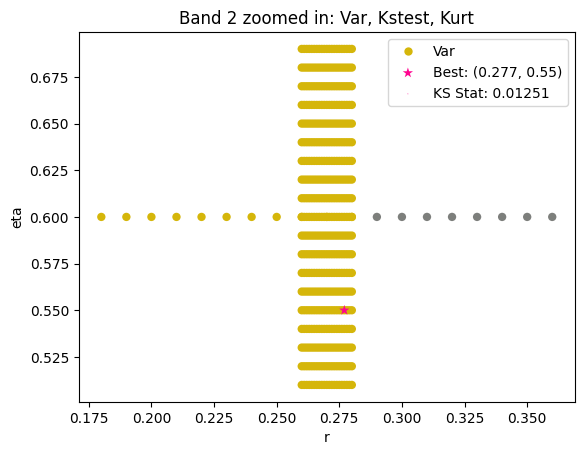

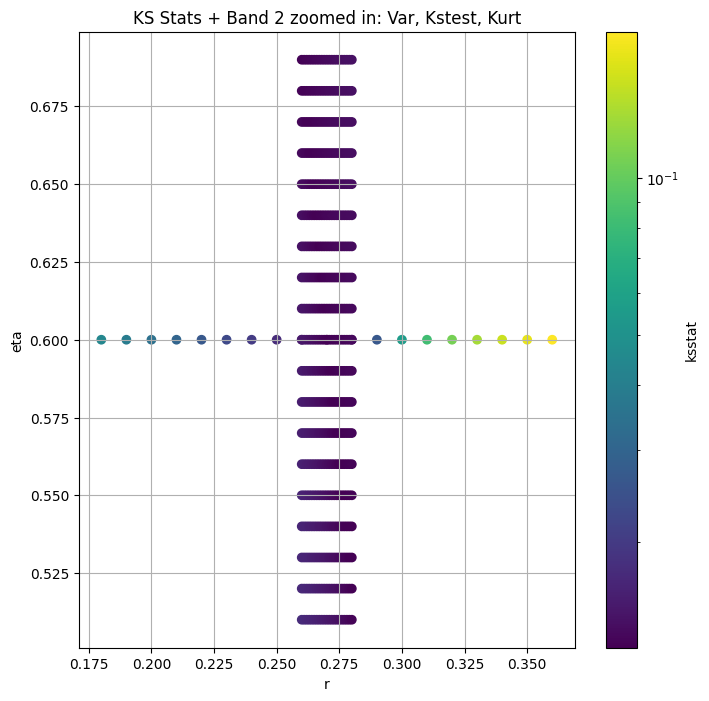

Band 5
(0.282, 0.09), 50 of 420
(0.284, 0.19), 100 of 420
(0.287, 0.09), 150 of 420
(0.289, 0.19), 200 of 420
(0.292, 0.09), 250 of 420
(0.294, 0.19), 300 of 420
(0.297, 0.09), 350 of 420
(0.299, 0.19), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 306.99it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 5 best parameters: ((0.288, 0.11), 0.012806693929513169)


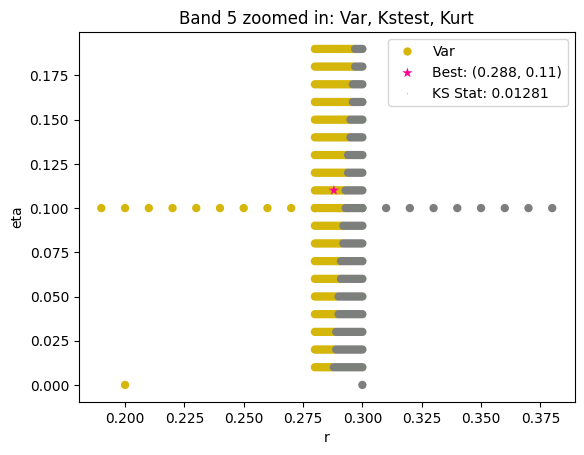

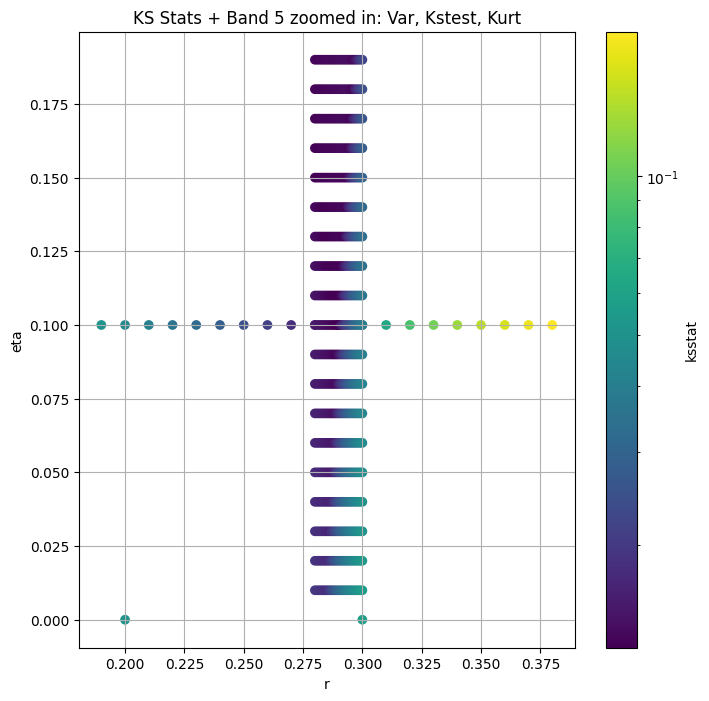

Band 8
(0.22, -0.009999999), 50 of 420
(0.24, 0.090000001), 100 of 420
(0.27, -0.009999999), 150 of 420
(0.29, 0.090000001), 200 of 420
(0.32, -0.009999999), 250 of 420
(0.34, 0.090000001), 300 of 420
(0.37, -0.009999999), 350 of 420
(0.39, 0.090000001), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 306.79it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 8 best parameters: ((0.31, -0.039999999), 0.00999707538097494)


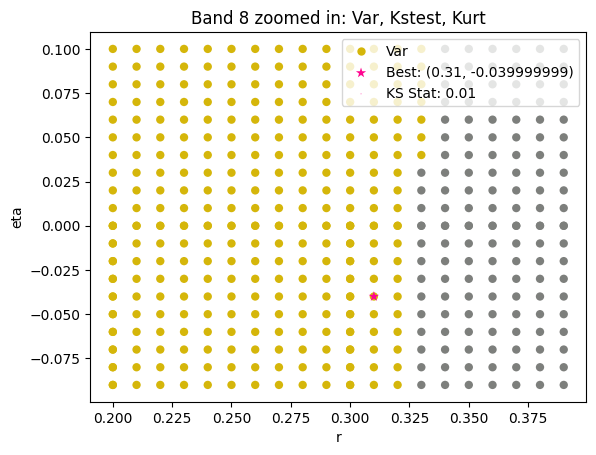

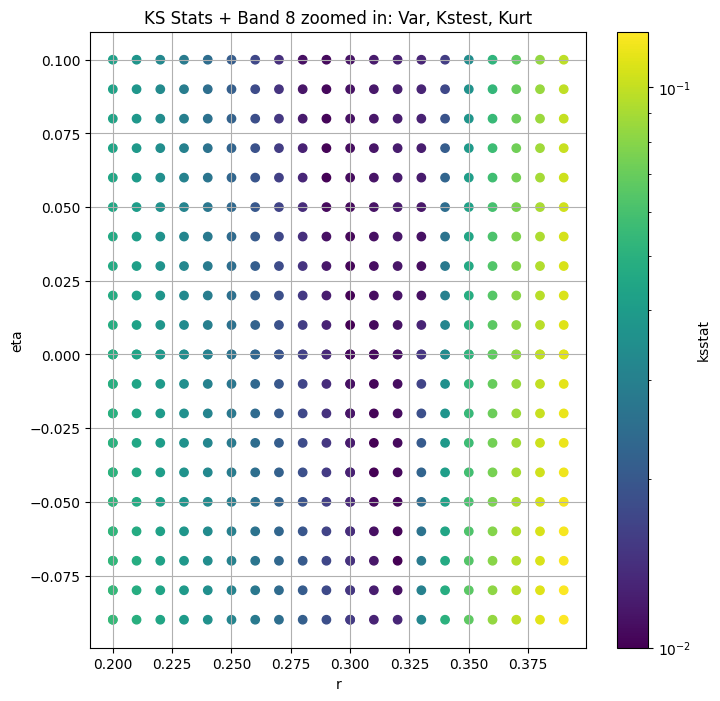

Band 11
(0.342, -0.23), 50 of 441
(0.344, -0.15), 100 of 441
(0.347, -0.28), 150 of 441
(0.349, -0.2), 200 of 441
(0.351, -0.12), 250 of 441
(0.354, -0.25), 300 of 441
(0.356, -0.17), 350 of 441
(0.359, -0.3), 400 of 441


100%|██████████| 441/441 [00:01<00:00, 308.89it/s]


Finding Minimum after computing 441 CDFs
Iter 1 band 11 best parameters: ((0.358, -0.24), 0.008794389235841693)


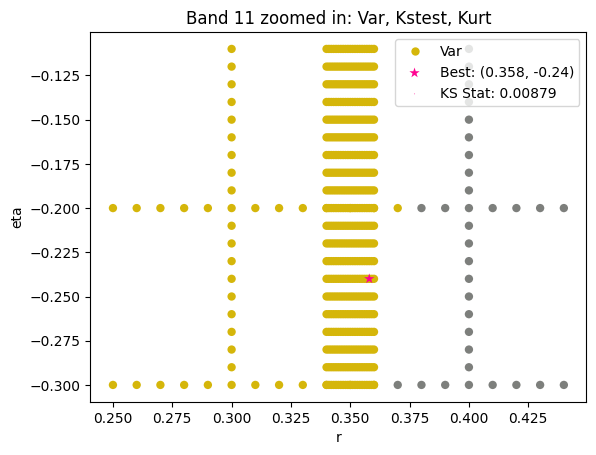

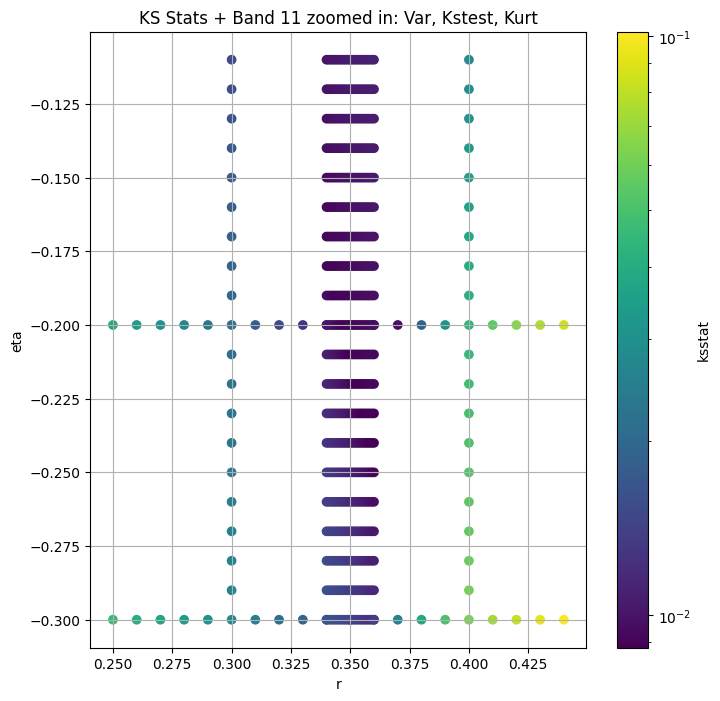

Band 14
(0.32, -0.443), 50 of 420
(0.34, -0.435), 100 of 420
(0.37, -0.448), 150 of 420
(0.39, -0.44), 200 of 420
(0.41, -0.432), 250 of 420
(0.44, -0.445), 300 of 420
(0.46, -0.437), 350 of 420
(0.49, -0.45), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 306.30it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 14 best parameters: ((0.4, -0.444), 0.007376651138152557)


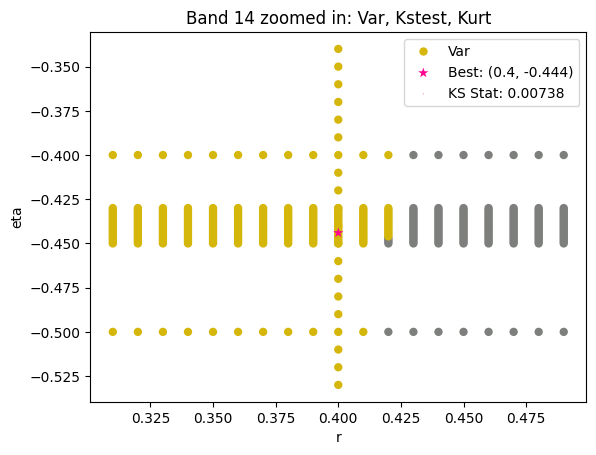

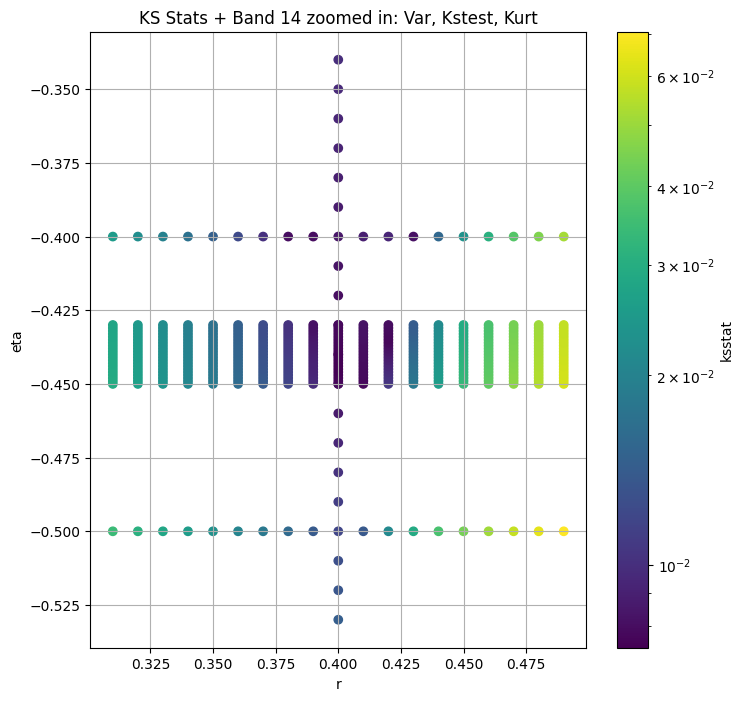

Band 17
(0.532, -0.61), 50 of 420
(0.534, -0.51), 100 of 420
(0.537, -0.61), 150 of 420
(0.539, -0.51), 200 of 420
(0.542, -0.61), 250 of 420
(0.544, -0.51), 300 of 420
(0.547, -0.61), 350 of 420
(0.549, -0.51), 400 of 420


100%|██████████| 420/420 [00:01<00:00, 307.65it/s]


Finding Minimum after computing 420 CDFs
Iter 1 band 17 best parameters: ((0.55, -0.58), 0.003716075495548754)


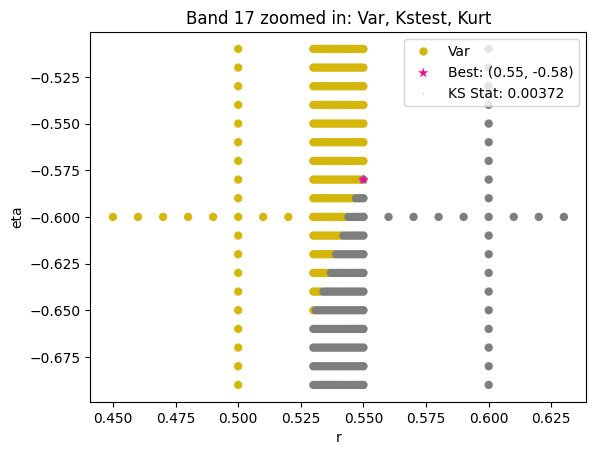

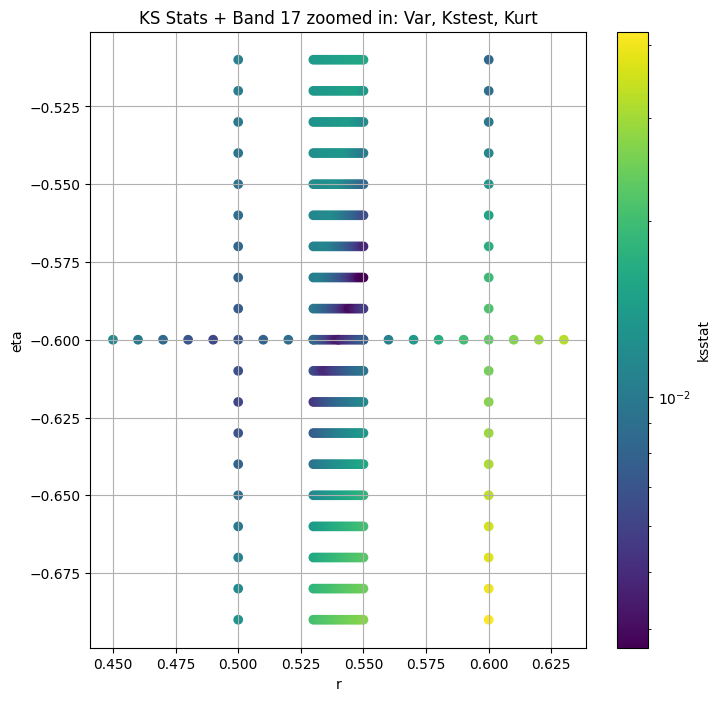

Band 20
(0.052, 6.59), 50 of 400
(0.054, 6.69), 100 of 400
(0.057, 6.59), 150 of 400
(0.059, 6.69), 200 of 400
(0.062, 6.59), 250 of 400
(0.064, 6.69), 300 of 400
(0.067, 6.59), 350 of 400
(0.069, 6.69), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:01<00:00, 296.28it/s]


Finding Minimum after computing 400 CDFs
Iter 1 band 20 best parameters: ((0.059, 6.69), 0.002407600524692022)


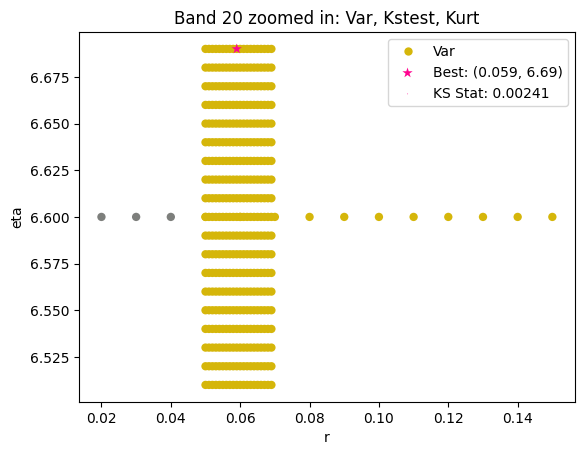

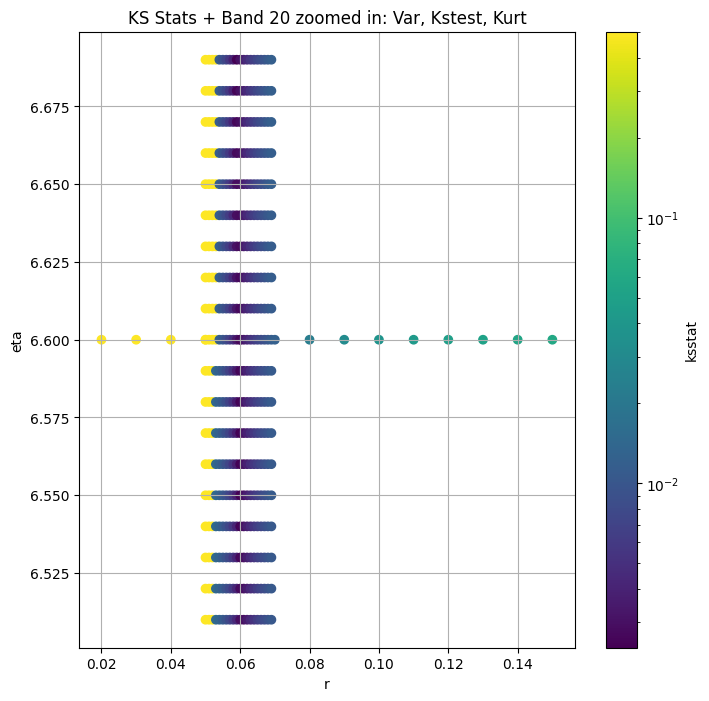

Band 23
(0.062, 8.29), 50 of 400
(0.064, 8.39), 100 of 400
(0.067, 8.29), 150 of 400
(0.069, 8.39), 200 of 400
(0.072, 8.29), 250 of 400
(0.074, 8.39), 300 of 400
(0.077, 8.29), 350 of 400
(0.079, 8.39), 400 of 400


/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: invalid value encountered in scalar divide
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar power
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/utilities/testing.py:590: RuntimeWarning: overflow encountered in scalar multiply
  kurtosis = scale*3*scipy.special.gamma(beta + 2/r)*scipy.special.gamma(beta)/scipy.special.gamma(beta+1/r)**2
100%|██████████| 400/400 [00:01<00:00, 305.59it/s]


Finding Minimum after computing 400 CDFs
Iter 1 band 23 best parameters: ((0.07, 8.31), 0.001408217852049809)


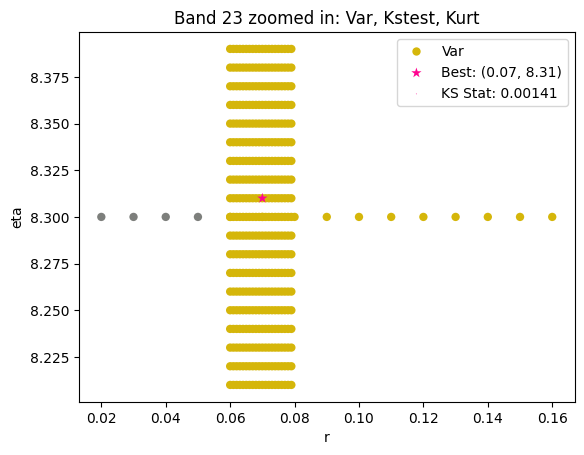

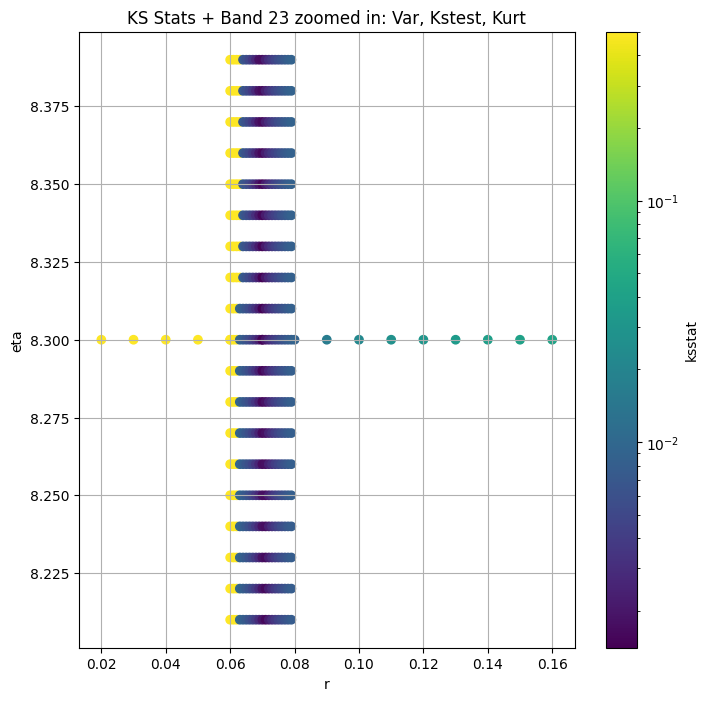

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  initial_r   initial_eta  initial_scale  ...  \
band                                                                      ...   
2        8.210644        47614.0       0.27  6.000000e-01   5.356433e+04  ...   
5       14.530108       102030.0       0.29  1.000000e-01   1.000000e+05  ...   
8       28.603450       326496.0       0.30  1.000000e-09   4.876507e+04  ...   
11      17.436117       904666.0       0.35 -2.000000e-01   6.909635e+04  ...   
14      27.891136      2727602.0       0.40 -4.400000e-01   8.172318e+04  ...   
17     200.073470      8298440.0       0.54 -6.000000e-01   1.000000e+05  ...   
20    1304.633700     25140192.0       0.06  6.600000e+00   8.466925e-32  ...   
23     247.719700     65734528.0       0.07  8.300000e+00   1.826442e-27  ...   

      best_scale_eta0  kstest_stat_eta0  best_r  best_eta    best_scale  \
band                                                                      
2          183.761758          0.253632   0.277     0.550  7.824447e+04   
5          183.761758          0.172826   0.288     0.110  9.189108e+04   
8          183.761758          0.067973   0.310    -0.040  7.139450e+04   
11         384.253672          0.011002   0.358    -0.240  8.774377e+04   
14        1338.339167          0.014683   0.400    -0.444  8.235144e+04   
17        6597.346049          0.017859   0.550    -0.580  1.000000e+05   
20       27368.266662          0.071230   0.059     6.690  1.312078e-32   
23       27368.266662          0.177880   0.070     8.310  1.801193e-27   

      kstest_stat_best  iter1_r  iter1_eta  kstest_stat_iter1  n_pval_0.05  
band                                                                        
2             0.012515    0.277      0.550           0.012515        11903  
5             0.012807    0.288      0.110           0.012807        10759  
8             0.009997    0.310     -0.040           0.009997        19368  
11            0.008794    0.358     -0.240           0.008794        23851  
14            0.007377    0.400     -0.444           0.007377        34131  
17            0.003716    0.550     -0.580           0.003716       129663  
20            0.002408    0.059      6.690           0.002408       331435  
23            0.001408    0.070      8.310           0.001408       974943  

[8 rows x 23 columns]

In [11]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))


SKIP_OPTIMIZE_STEP = False
NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS)))
NUM_SAMPLES_OPTIMIZE = 2000

if RERUN or not master_df_optimized_path.exists():
    rEtaKsstats_dict = dict()

    if SKIP_OPTIMIZE_STEP:
        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
    else:
        for group in GROUPS: 
            print(f"{GROUP.capitalize()} {group}")
            sample = group_data_map[group]
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            r_granularity = 10
            eta_granularity = 10
            for i in range(0, -5, -1):
                if tuple([round_to_sigfigs(initial_r + 10.**i, 8), initial_eta]) in all_cdfs:
                    r_granularity = 10.**i
                if tuple([initial_r, round_to_sigfigs(initial_eta + 10.**i, 8)]) in all_cdfs:
                    
                    eta_granularity = 10.**i

            for d in range(1, NUM_ITERS[group] + 1):
                if d == 1:
                    initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
                else:
                    initial_r, initial_eta = master_df.loc[group, f'iter{d - 1}_r'], master_df.loc[group, f'iter{d - 1}_eta']
                r_granularity = r_granularity * 10.0**(-d+1) 
                eta_granularity = eta_granularity * 10.0**(-d+1) 

                r_range = [round_to_sigfigs(x) for x in np.arange(initial_r - r_granularity, initial_r + r_granularity, r_granularity/10)]
                eta_range = [round_to_sigfigs(x) for x in np.arange(initial_eta - eta_granularity, initial_eta + eta_granularity, eta_granularity/10)]
                simple_add_cdfs(r_range, eta_range, dir = os.path.join(CWD, "groupCDFs"), folder_name=f'{GROUP}{group}', n_samples = NUM_SAMPLES_OPTIMIZE, debug=False, tail_bound=1e-5)
                cdfs_dict = combine_pickles(os.path.join(CWD, "groupCDFs", f'{GROUP}{group}'))
                

                temp_df = create_kurt_var_ksstat_df(cdfs_dict)
                temp_df['scale'] = np.clip(master_df.loc[group,'obs_var'] / temp_df['variance'], 0, 1e5)
                temp_df['variance'] = temp_df['variance'] * temp_df['scale']
                temp_df['kurtosis'] = temp_df['kurtosis'] * temp_df['scale']
                ksstats, best_param, kstest_stat = gridsearch(sample, cdfs_dict, debug=True, scales=temp_df['scale'])
                temp_df = add_tests_to_df(cdfs_df=temp_df, group=group, var_kurt_df=master_df, ksstats=ksstats)
                
                group_cdf_df_dict[group] = pd.concat([group_cdf_df_dict[group], temp_df])
                master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta'] = best_param[0], best_param[1]
                best_scale = temp_df.loc[(temp_df["r"] ==  best_param[0])&(temp_df["eta"] ==  best_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'best_scale'] = best_scale
                master_df.loc[group, 'kstest_stat_best'] = kstest_stat
                master_df.loc[group, f'iter{d}_r'], master_df.loc[group, f'iter{d}_eta'] = best_param[0], best_param[1]
                master_df.loc[group, f'kstest_stat_iter{d}'] = kstest_stat
                
                print(f"Iter {d} {GROUP} {group} best parameters: {best_param, master_df.loc[group, f'kstest_stat_iter{d}']}")

            temp_df = group_cdf_df_dict[group].sort_values(['r', 'eta'])
            rEtaKsstats_dict[group] = [temp_df['r'], temp_df['eta'], temp_df['ksstat']]

            eps = 0.1
            filtered_df = temp_df[(temp_df['r'] > master_df.loc[group, 'initial_r'] - eps) & 
                            (temp_df['r'] < master_df.loc[group, 'initial_r'] + eps) &
                            (temp_df['eta'] > master_df.loc[group, 'initial_eta'] - eps) &
                            (temp_df['eta'] < master_df.loc[group, 'initial_eta'] + eps)]
            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(filtered_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=kstest_stat)
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=300)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    pd.to_pickle(rEtaKsstats_dict, os.path.join(CWD, "cache", 'rEtaKsstats_dict.pickle'))

master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

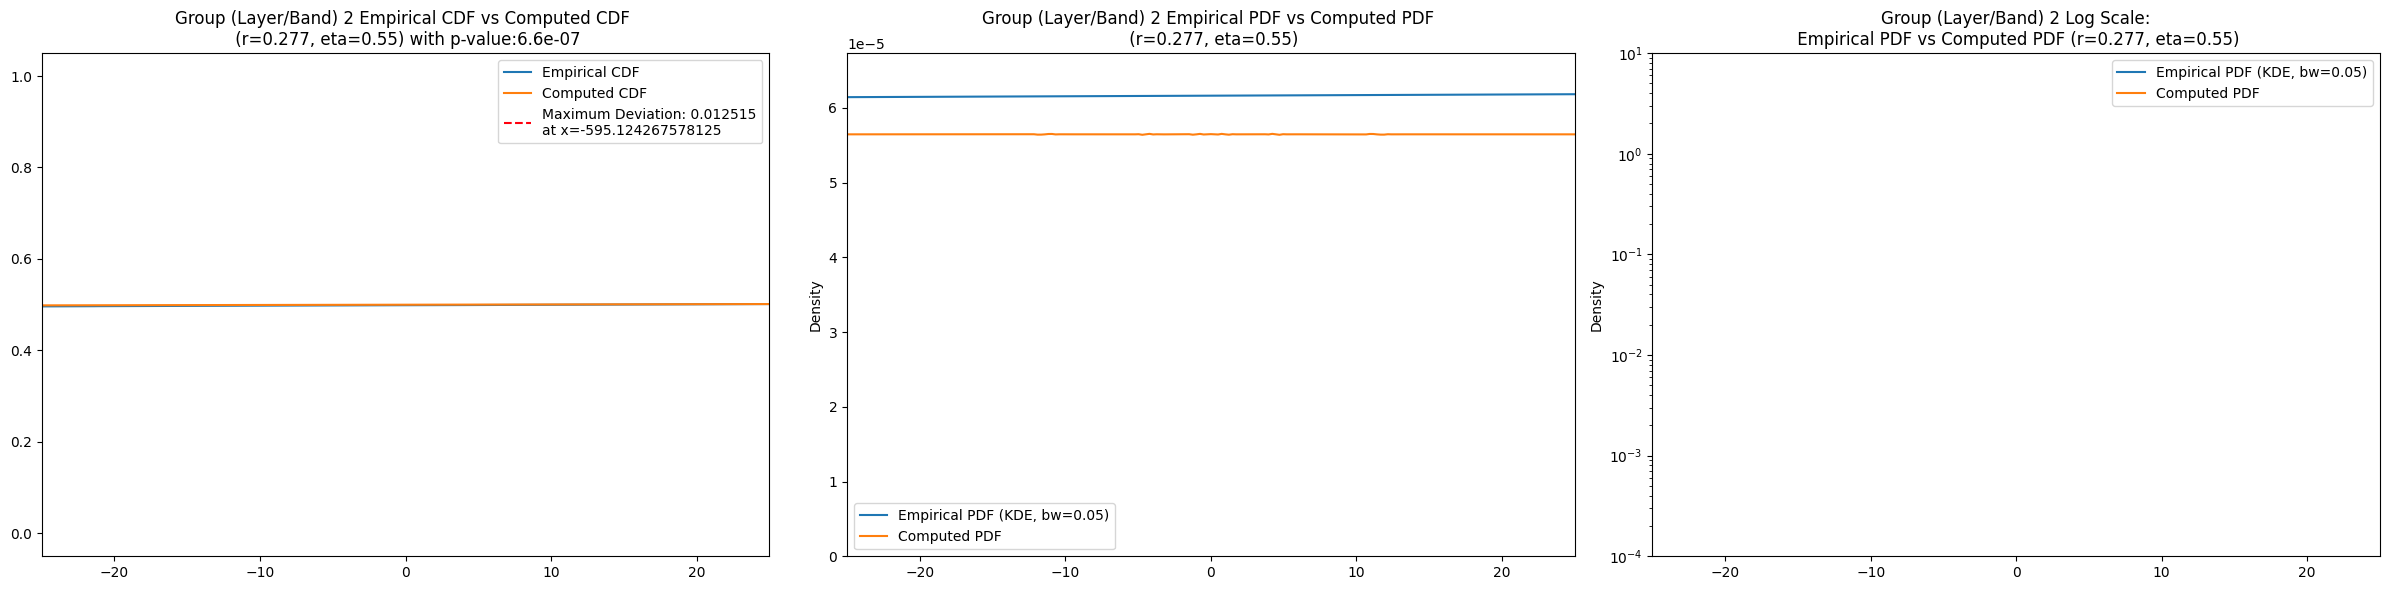

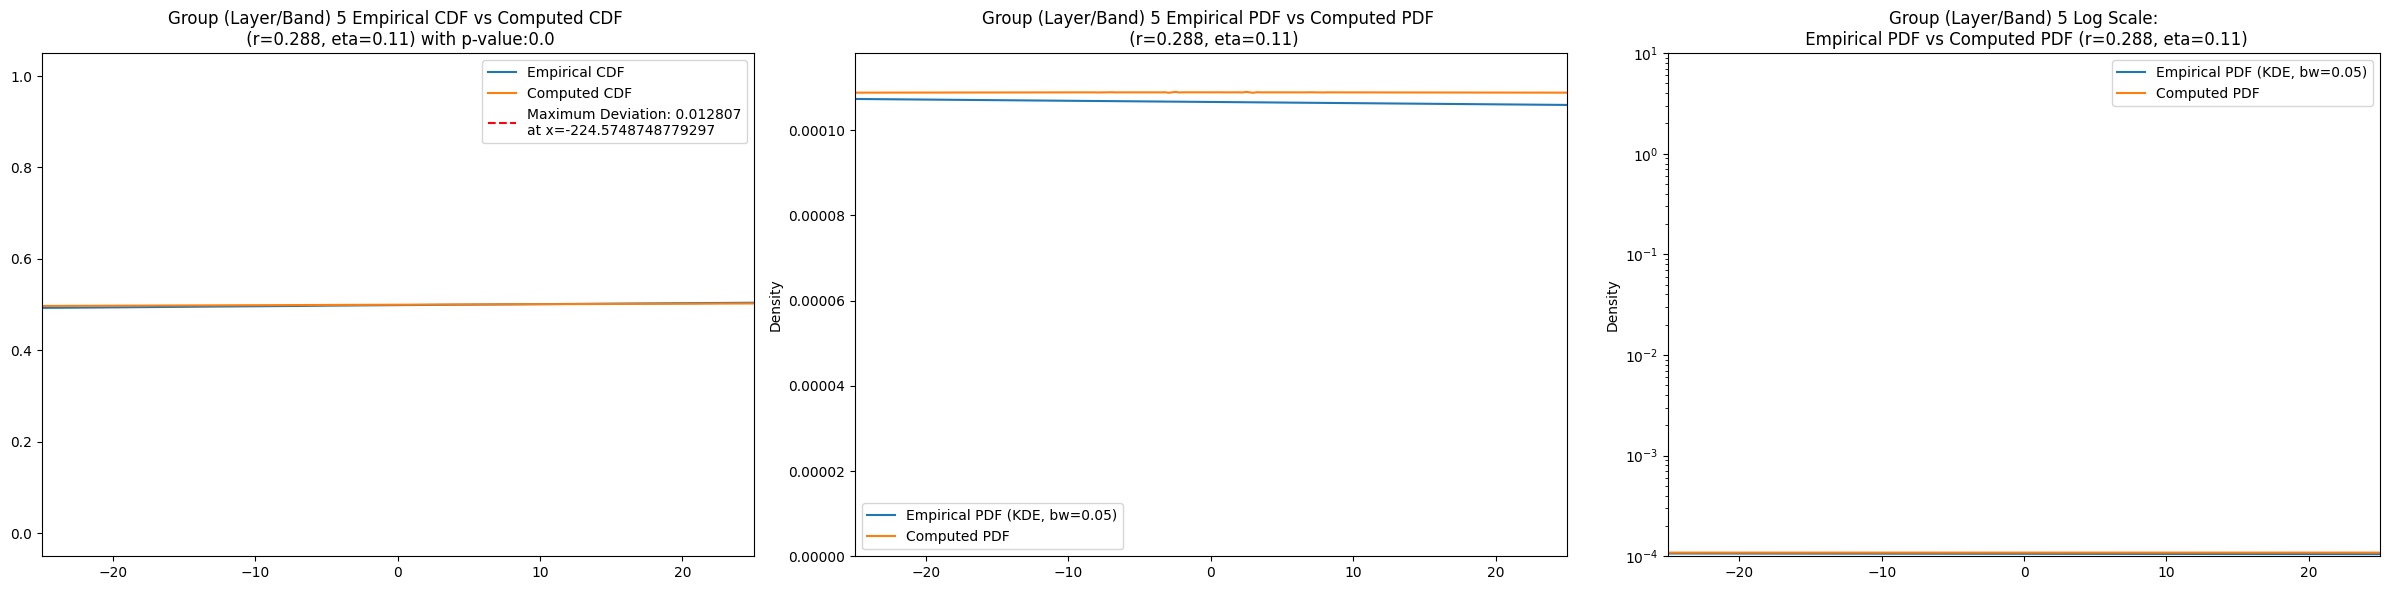

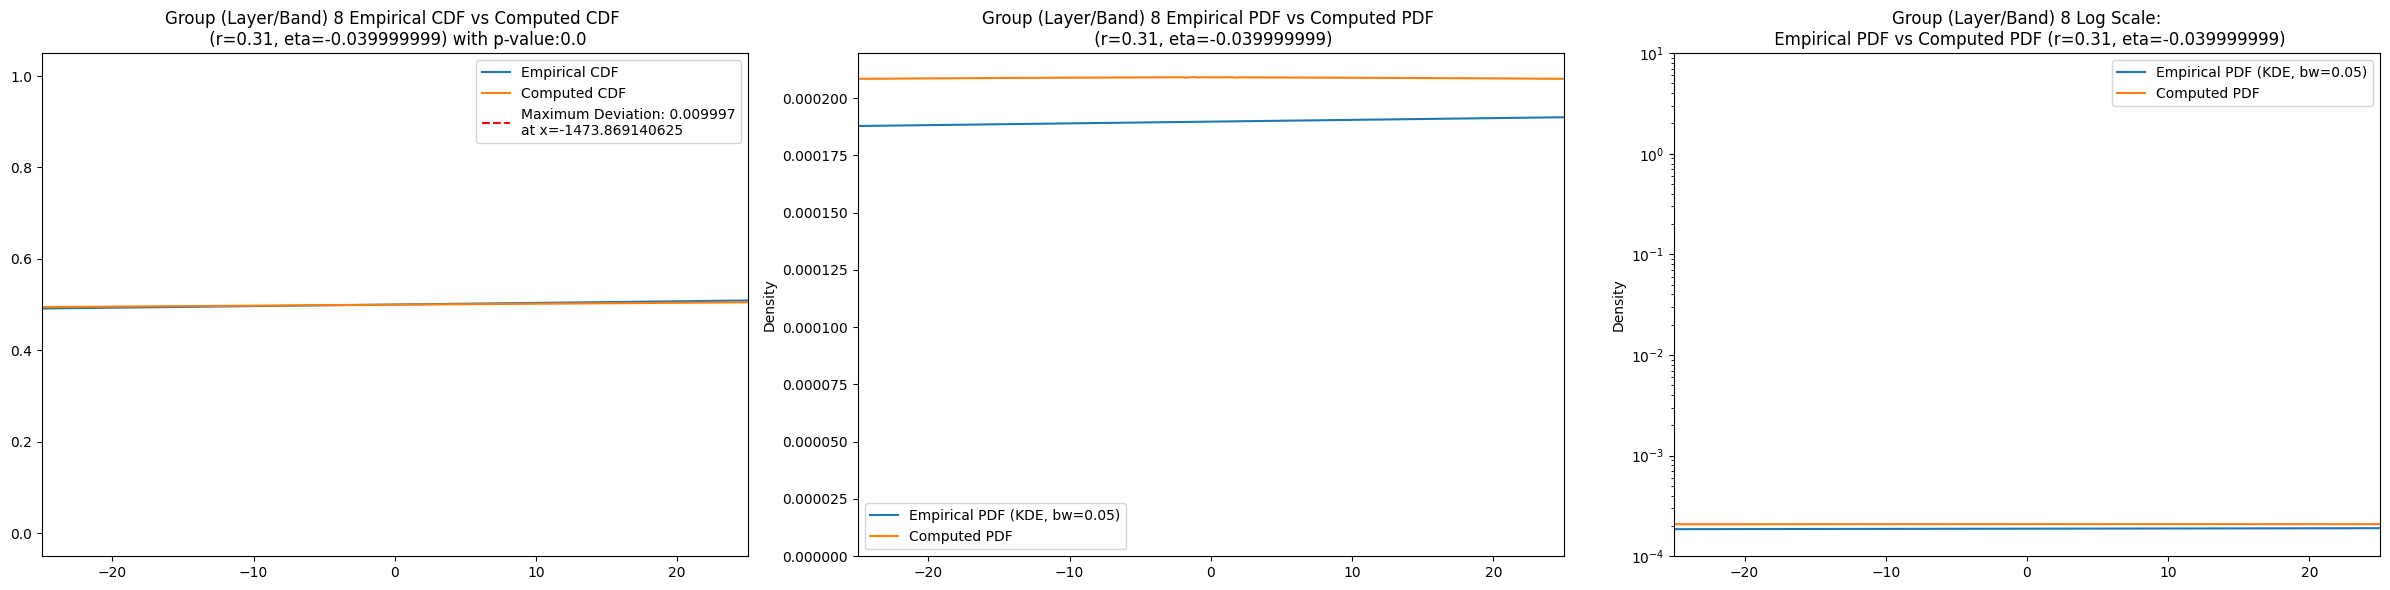

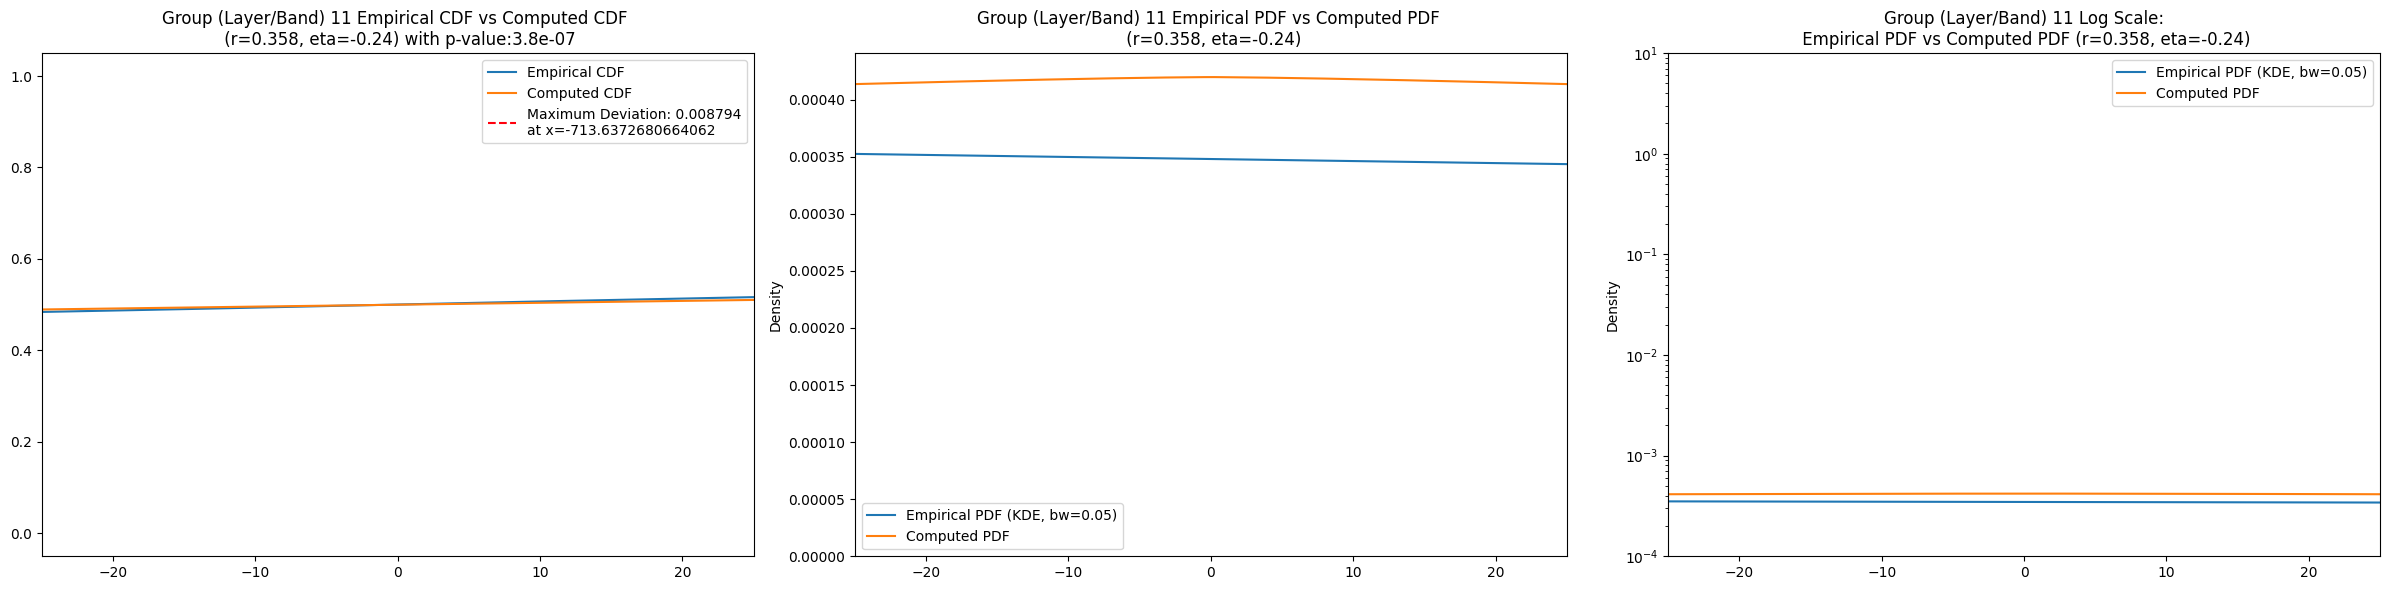

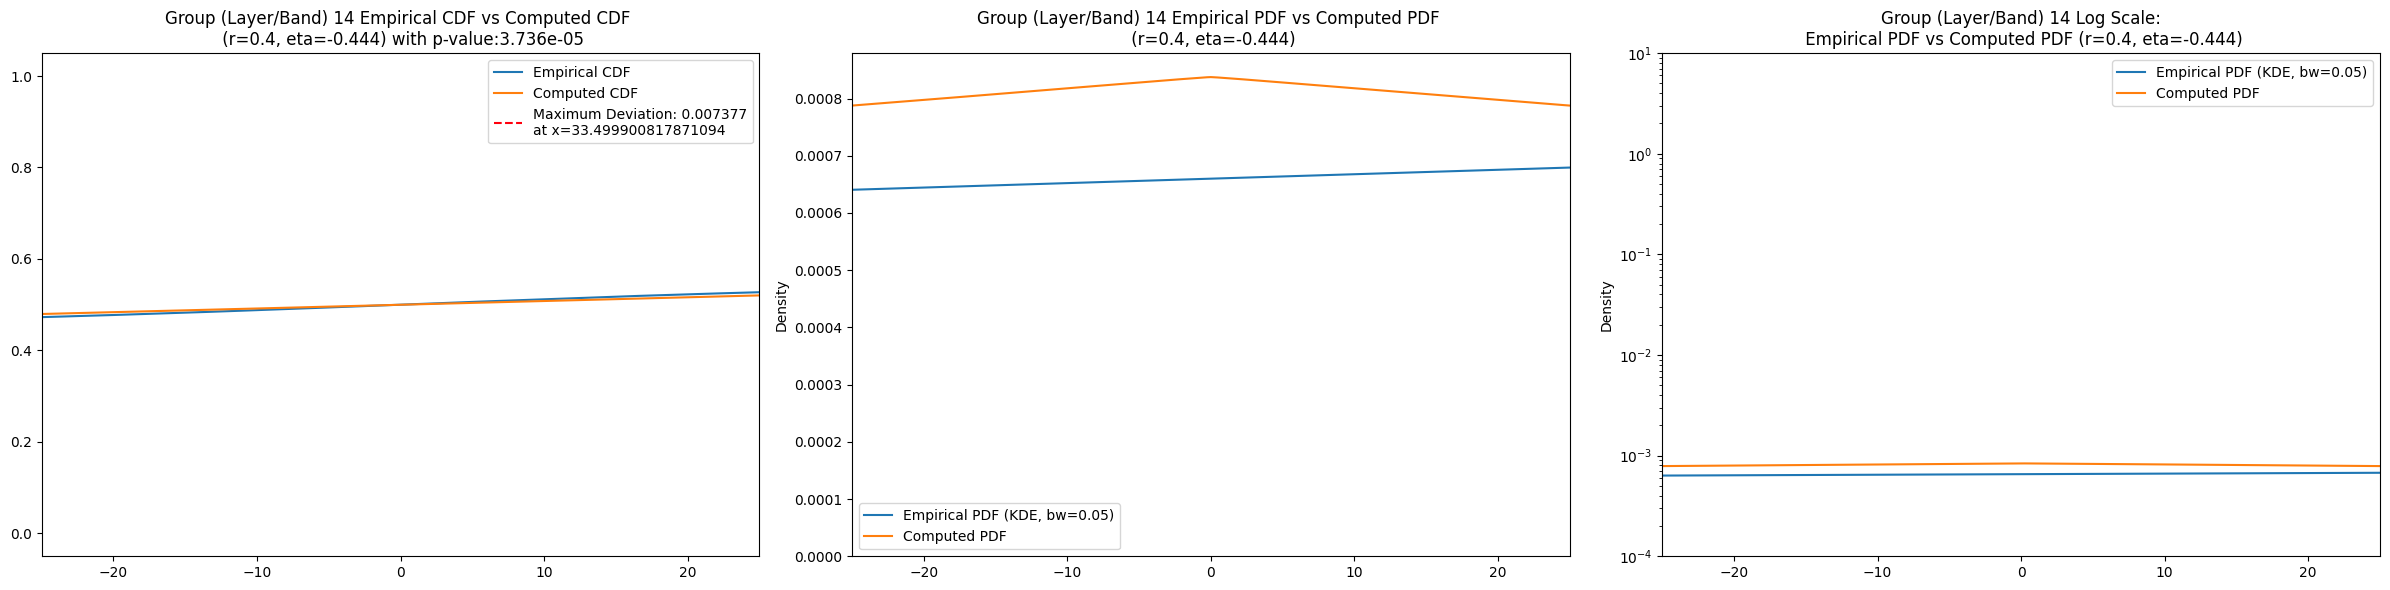

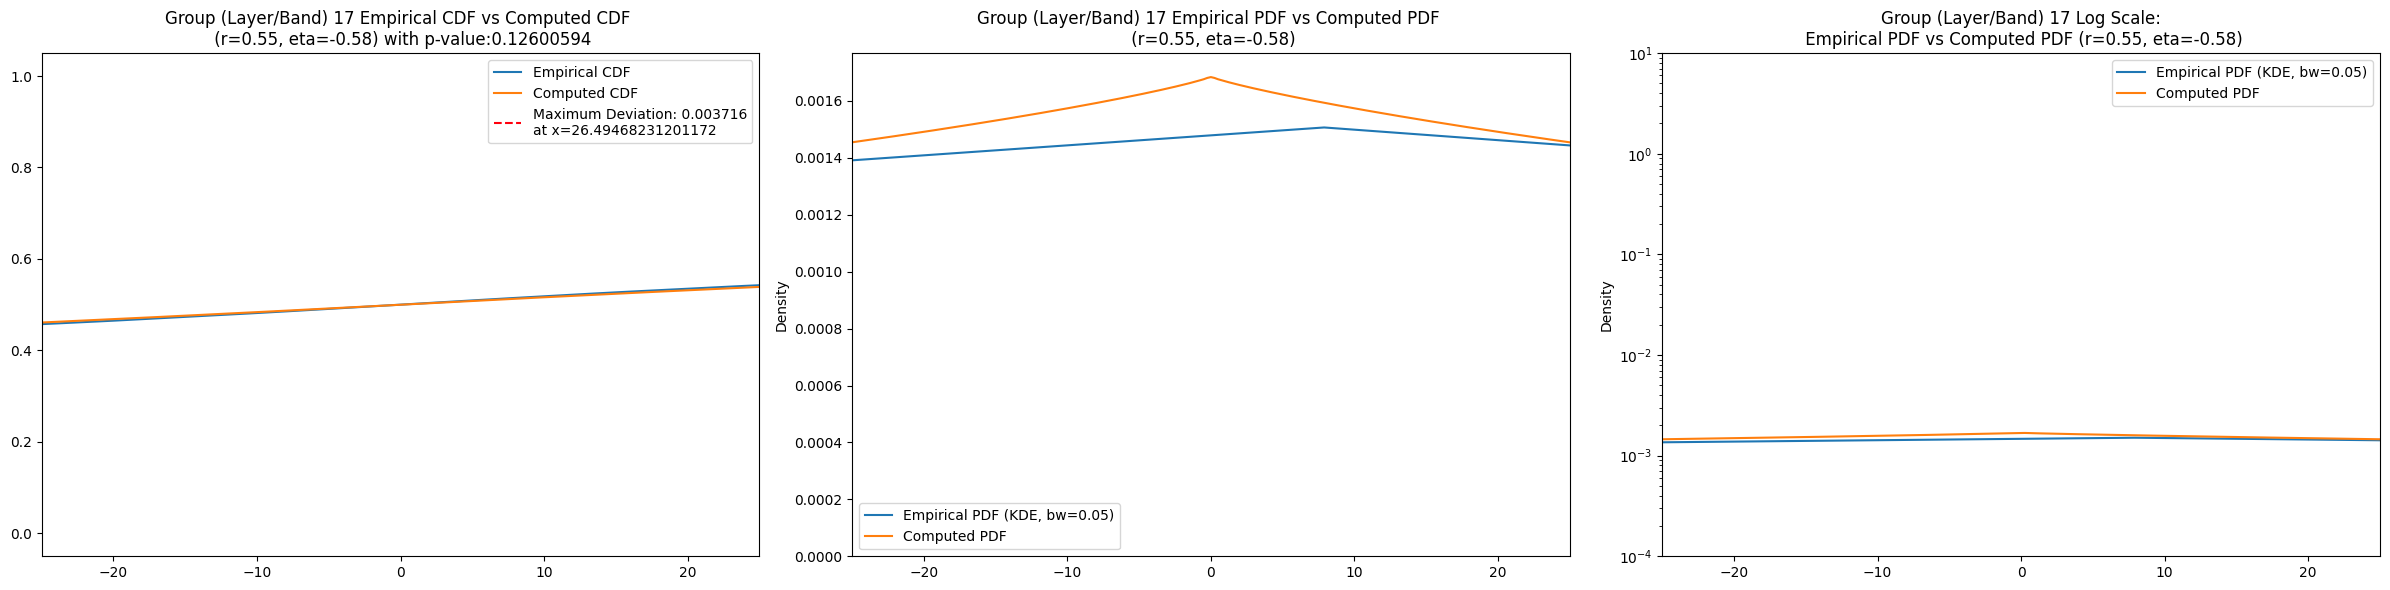

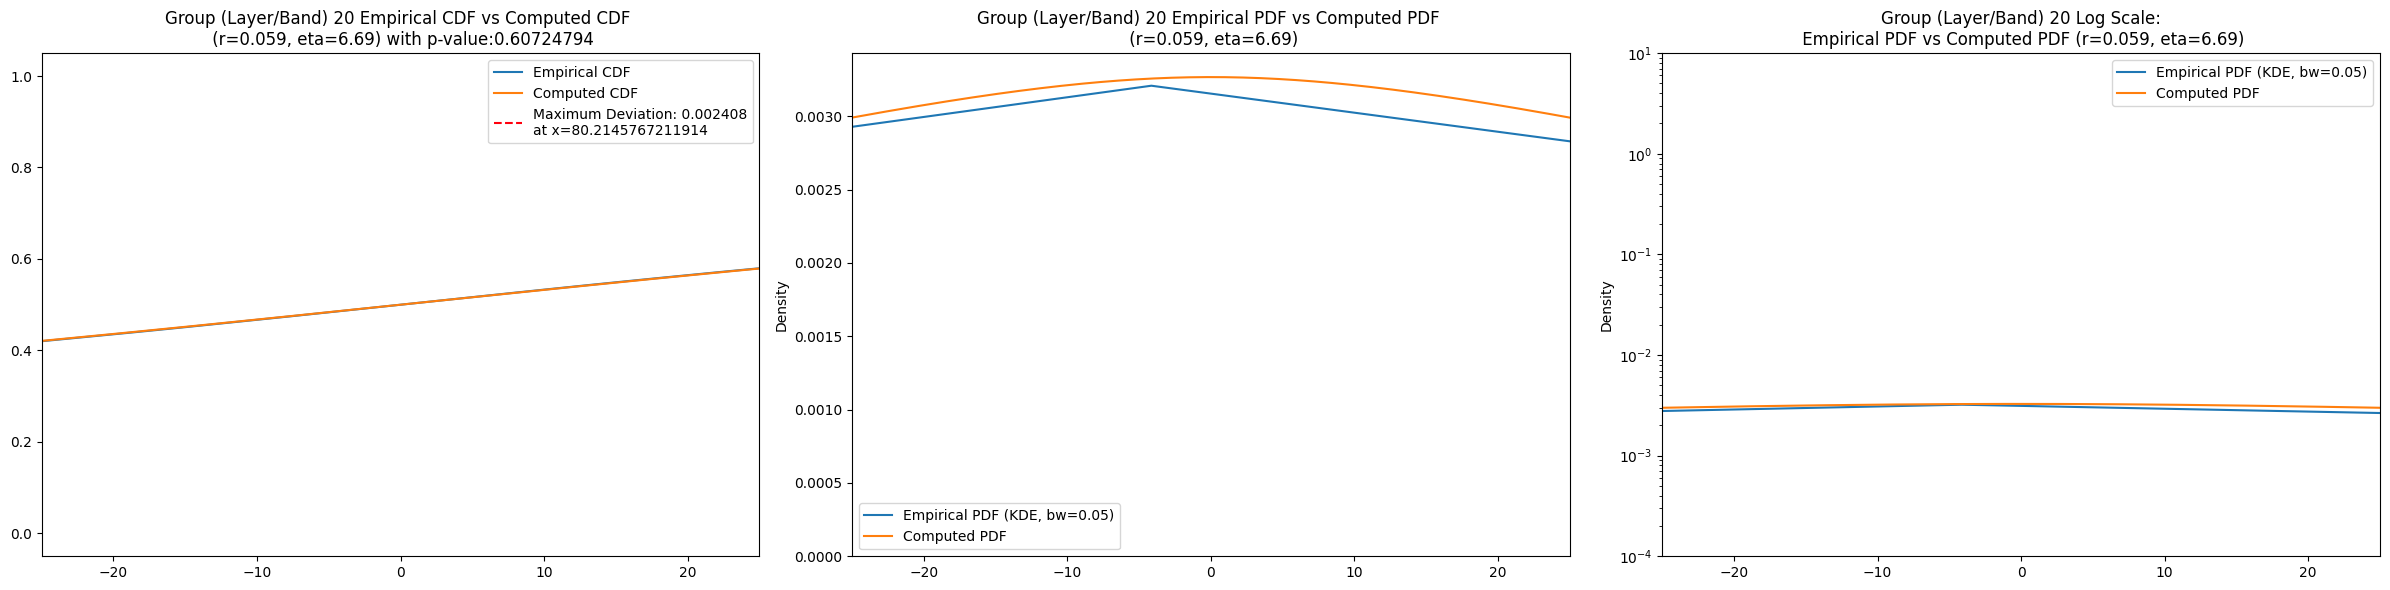

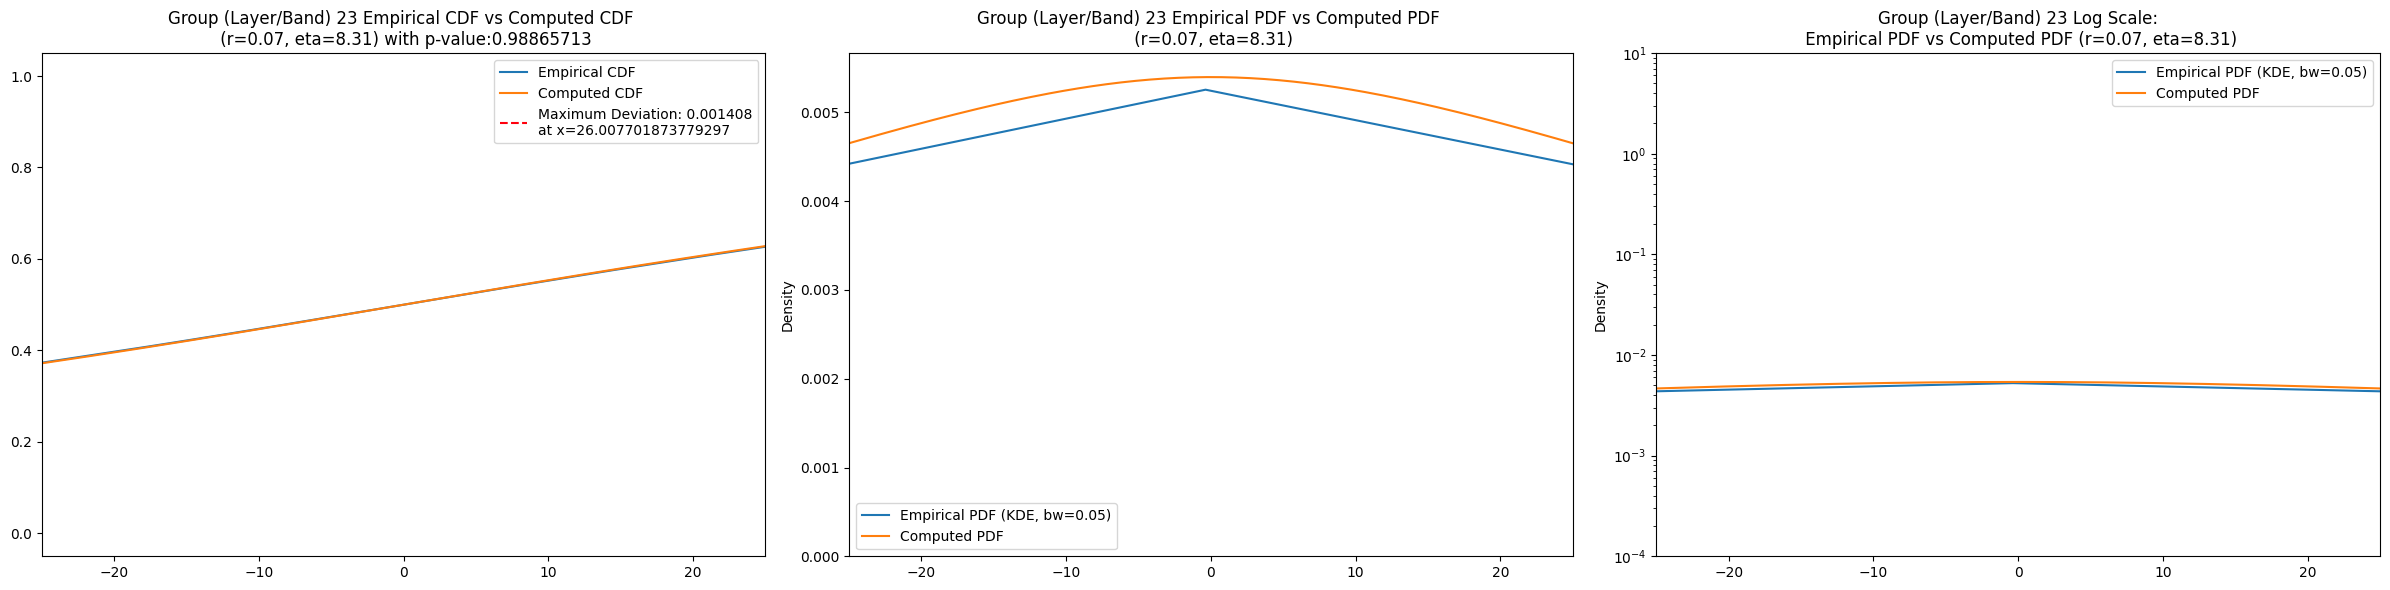

In [12]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 600)

## Comparing with Gaussian and Laplace Priors

In [13]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample / np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [14]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  initial_r   initial_eta  initial_scale  ...  \
band                                                                      ...   
2        8.210644        47614.0       0.27  6.000000e-01   5.356433e+04  ...   
5       14.530108       102030.0       0.29  1.000000e-01   1.000000e+05  ...   
8       28.603450       326496.0       0.30  1.000000e-09   4.876507e+04  ...   
11      17.436117       904666.0       0.35 -2.000000e-01   6.909635e+04  ...   
14      27.891136      2727602.0       0.40 -4.400000e-01   8.172318e+04  ...   
17     200.073470      8298440.0       0.54 -6.000000e-01   1.000000e+05  ...   
20    1304.633700     25140192.0       0.06  6.600000e+00   8.466925e-32  ...   
23     247.719700     65734528.0       0.07  8.300000e+00   1.826442e-27  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2         10095.6000              0.035486          1.576350e-52   
5          5825.9000              0.037760         7.797850e-127   
8          3099.0600              0.036875          0.000000e+00   
11         1596.4700              0.036988          0.000000e+00   
14          862.6090              0.039586          0.000000e+00   
17          423.2470              0.038419          0.000000e+00   
20          172.6870              0.035129          0.000000e+00   
23           95.0608              0.028802          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         8515.0400             0.012075         1.852180e-06  7177.4000   
5         4883.8700             0.014785         8.362540e-20  4067.8400   
8         2624.4500             0.012684         4.675760e-46  2151.3500   
11        1359.6100             0.012363        1.539900e-120  1103.7000   
14         748.7630             0.013562         0.000000e+00   594.1990   
17         370.8270             0.011843         0.000000e+00   292.8240   
20         152.1530             0.009058         0.000000e+00   121.9470   
23          82.2881             0.005189         0.000000e+00    67.2484   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017166   1.282810e-12          6.603233e-07  
5          0.019197   4.302820e-33          5.778072e-15  
8          0.016137   2.793370e-74          9.016303e-29  
11         0.015718  1.457950e-194          3.341927e-61  
14         0.016523   0.000000e+00         2.403387e-129  
17         0.014978   0.000000e+00         5.808139e-100  
20         0.008861   0.000000e+00         5.299314e-127  
23         0.006323   0.000000e+00         1.186484e-113  

[8 rows x 33 columns]

## Results

In [15]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [16]:
master_df

obs_var     var_lower     var_upper    obs_kurt  kurt_lower  \
band                                                                     
2     1.887024e+08  1.756754e+08  2.026537e+08    5.769590    4.088155   
5     6.992360e+07  6.431123e+07  7.625714e+07    8.911055    5.411636   
8     2.019705e+07  1.848095e+07  2.224740e+07   10.603689    5.844239   
11    5.333559e+06  4.899587e+06  5.816535e+06    9.182022    5.623513   
14    1.659427e+06  1.519871e+06  1.827128e+06   10.649116    5.947791   
17    4.078040e+05  3.659843e+05  5.032684e+05   34.724663    6.520162   
20    6.877905e+04  5.809956e+04  1.272616e+05  315.785860    6.707434   
23    1.606007e+04  1.458438e+04  2.048627e+04   39.690777    4.401589   

       kurt_upper  total_samples  initial_r   initial_eta  initial_scale  ...  \
band                                                                      ...   
2        8.210644        47614.0       0.27  6.000000e-01   5.356433e+04  ...   
5       14.530108       102030.0       0.29  1.000000e-01   1.000000e+05  ...   
8       28.603450       326496.0       0.30  1.000000e-09   4.876507e+04  ...   
11      17.436117       904666.0       0.35 -2.000000e-01   6.909635e+04  ...   
14      27.891136      2727602.0       0.40 -4.400000e-01   8.172318e+04  ...   
17     200.073470      8298440.0       0.54 -6.000000e-01   1.000000e+05  ...   
20    1304.633700     25140192.0       0.06  6.600000e+00   8.466925e-32  ...   
23     247.719700     65734528.0       0.07  8.300000e+00   1.826442e-27  ...   

      param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
band                                                               
2         10095.6000              0.035486          1.576350e-52   
5          5825.9000              0.037760         7.797850e-127   
8          3099.0600              0.036875          0.000000e+00   
11         1596.4700              0.036988          0.000000e+00   
14          862.6090              0.039586          0.000000e+00   
17          423.2470              0.038419          0.000000e+00   
20          172.6870              0.035129          0.000000e+00   
23           95.0608              0.028802          0.000000e+00   

      param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
band                                                                       
2         8515.0400             0.012075         1.852180e-06  7177.4000   
5         4883.8700             0.014785         8.362540e-20  4067.8400   
8         2624.4500             0.012684         4.675760e-46  2151.3500   
11        1359.6100             0.012363        1.539900e-120  1103.7000   
14         748.7630             0.013562         0.000000e+00   594.1990   
17         370.8270             0.011843         0.000000e+00   292.8240   
20         152.1530             0.009058         0.000000e+00   121.9470   
23          82.2881             0.005189         0.000000e+00    67.2484   

      kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
band                                                      
2          0.017166   1.282810e-12          6.603233e-07  
5          0.019197   4.302820e-33          5.778072e-15  
8          0.016137   2.793370e-74          9.016303e-29  
11         0.015718  1.457950e-194          3.341927e-61  
14         0.016523   0.000000e+00         2.403387e-129  
17         0.014978   0.000000e+00         5.808139e-100  
20         0.008861   0.000000e+00         5.299314e-127  
23         0.006323   0.000000e+00         1.186484e-113  

[8 rows x 33 columns]

In [17]:
eng.quit()
remove_directory(os.path.join(CWD, "groupCDFs"))